## KAN RL

In [ ]:
!pip install moviepy~=1.0.3 gymnasium pykan~=0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 61.0 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=90408ab2a8c5186364228ba3609caed018932dbcb2fb927929fc4af7a796455f
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


## Models

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5800147.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 151743.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1442911.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2637116.39it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(4)
Feedback shape: torch.Size([1, 8, 8])


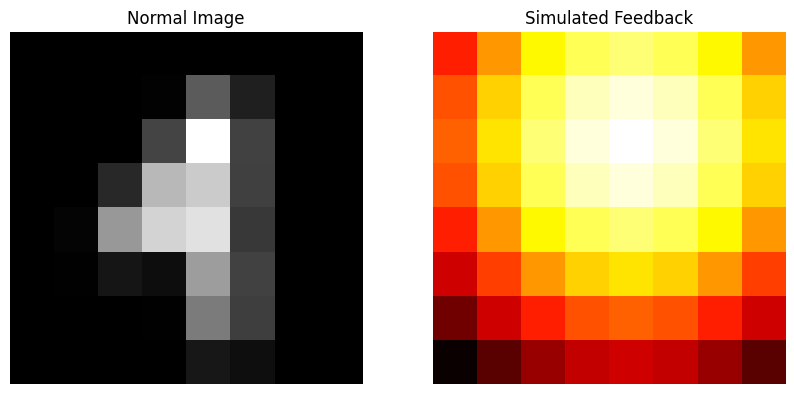

tensor(0.4404) tensor(1.)


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py  for normalization values computation

class BenchmarkEnvironment:
    def __init__(self, dataset_name='MNIST', batch_size=128, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.num_channels = 1  # Force single channel for all datasets

        if dataset_name == 'MNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            self.dataset = datasets.MNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'FashionMNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR10':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Pad(4),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR10('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR100':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Pad(4),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR100('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'SVHN':
            self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.SVHN('./data', split='train', download=True, transform=self.transform)

        elif dataset_name == 'KMNIST':
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.KMNIST('./data', train=True, download=True, transform=self.transform)

        else:
            raise ValueError(f"Dataset {dataset_name} is not supported.")


        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback


    def generate_simulated_feedback(self, image_tensor):
        # If the image has 3 channels (RGB), average them into a single channel
        if image_tensor.shape[1] == 3:  # Check if there are 3 channels (RGB)
            image_np = image_tensor.mean(dim=1).squeeze().numpy()  # Average across channels
        else:  # For grayscale or single-channel images
            image_np = image_tensor.squeeze().numpy()

        # Normalize the image to [0, 1]
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        # Calculate the center of mass
        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape[-2:]))

        # Generate a Gaussian feedback mask based on the center of mass
        x, y = np.meshgrid(np.arange(image_np.shape[-1]), np.arange(image_np.shape[-2]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        # Normalize the feedback mask
        feedback = gaussian_mask / np.max(gaussian_mask)

        # Return the feedback as a tensor
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)

def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Check if the normal image has 3 channels (RGB)
    if normal_image_np.ndim == 3 and normal_image_np.shape[0] == 3:  # RGB image
        # Transpose to (height, width, channels) for imshow
        normal_image_np = normal_image_np.transpose(1, 2, 0)
        axes[0].imshow(normal_image_np)
    else:  # Grayscale image
        axes[0].imshow(normal_image_np, cmap='gray')

    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image (assumed to be single-channel, displayed with 'hot' colormap)
    axes[1].imshow(feedback_image_np, cmap='hot')
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()


# Example usage:
if __name__ == "__main__":
    env = BenchmarkEnvironment(dataset_name='MNIST', batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())


In [ ]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        # self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, input_shape[0], input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 1  # Specify the desired number of convolutional layers
num_filters = 2 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
torch.Size([1, 64])


In [ ]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):


    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)



2024-11-01 16:20:37.304072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 16:20:37.304214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 16:20:37.478871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = BenchmarkEnvironment(dataset_name='MNIST', batch_size=config["batch_size"], feedback_sigma=5.0)    #MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_SVHN_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])

              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())


          correct = 0
          total = 0
          with torch.no_grad():
                  # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
                  # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
                  # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
              for images, labels in DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                             #split='test', download=True, transform=transforms.Compose([
                                                             #train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  #transforms.Grayscale(num_output_channels=1)
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])

                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent


In [ ]:

# config = {
#     "batch_size": 128,
#     "n_epochs": 5,
#     "gamma": 0.8,
#     "learning_rate": 1e-3, # 0.0005
#     "weight_decay": 1e-4,
#     "width": 8,
#     "grid": 3,
#     "method": "KAN",  # "MLP", "KAN"
#     "seed": 0,
#     "input_size": 8 * 8, # number of features
#     "output_size": 10, # number of classes
#     "buffer_size": 100000,
#     "target_update": 10,
#     "warm_up_episodes": 2,
#     "num_filters": 4,
#     "num_conv_layers": 2,
#     "first_channel": 1, # (1,8,8)
#     "hidden_dim": 128,
#     "feature_selection": True,
#     "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
#     "initial_tau": 1.0, # positive float value

# }

# q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 1, 3, 5], input_shape=(1, 8, 8)):
#     # Determine the side length of the image
#     side_length = int(np.sqrt(probs_history[0].shape[1]))

#     fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#     for i, epoch in enumerate(epochs):
#         ax = axes[i // 2, i % 2]
#         if epoch < len(probs_history):
#             probs = probs_history[epoch].flatten()
#             if side_length ** 2 != probs.shape[0]:
#                 continue
#             probs_image = probs.reshape((side_length, side_length))
#             cax = ax.matshow(probs_image, cmap='viridis')
#             fig.colorbar(cax, ax=ax)
#             ax.set_title(f'Probabilities at Epoch {epoch}')
#         else:
#             ax.axis('off')

#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(10, 5))
#     plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
#     plt.xlabel('Epoch')
#     plt.ylabel('Feedback Cost')
#     plt.title('Evolution of Feedback Cost (MSE)')
#     plt.legend()
#     plt.show()


# plot_evolution(probs_history, feedback_cost_history)


# MLP

In [ ]:
!pip install torchview

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
64


MLP_SVHN_0_1730478061:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06410841626335563
 Train accuracy:  0.09381663113006397 | 


MLP_SVHN_0_1730478061:   1%|          | 1/100 [00:04<07:56,  4.81s/it]

 Test accuracy:  0.177

correct: 48 total: 469
loss: 0.08360908366342597
 Train accuracy:  0.1023454157782516 | 


MLP_SVHN_0_1730478061:   2%|▏         | 2/100 [00:09<08:05,  4.96s/it]

 Test accuracy:  0.2038

correct: 107 total: 469
loss: 0.08937056103685517
 Train accuracy:  0.2281449893390192 | 


MLP_SVHN_0_1730478061:   3%|▎         | 3/100 [00:15<08:10,  5.06s/it]

 Test accuracy:  0.2771

correct: 137 total: 469
loss: 0.09811383558870125
 Train accuracy:  0.2921108742004264 | 


MLP_SVHN_0_1730478061:   4%|▍         | 4/100 [00:20<08:14,  5.15s/it]

 Test accuracy:  0.3163

correct: 146 total: 469
loss: 0.10292090612179688
 Train accuracy:  0.31130063965884863 | 


MLP_SVHN_0_1730478061:   5%|▌         | 5/100 [00:26<08:31,  5.39s/it]

 Test accuracy:  0.3467

correct: 159 total: 469
loss: 0.10658550332350009
 Train accuracy:  0.3390191897654584 | 


MLP_SVHN_0_1730478061:   6%|▌         | 6/100 [00:31<08:27,  5.40s/it]

 Test accuracy:  0.3724

correct: 166 total: 469
loss: 0.10952318713926812
 Train accuracy:  0.35394456289978676 | 


MLP_SVHN_0_1730478061:   7%|▋         | 7/100 [00:37<08:35,  5.54s/it]

 Test accuracy:  0.3873

correct: 199 total: 469
loss: 0.11131546473198099
 Train accuracy:  0.42430703624733473 | 


MLP_SVHN_0_1730478061:   8%|▊         | 8/100 [00:43<08:36,  5.61s/it]

 Test accuracy:  0.4062

correct: 194 total: 469
loss: 0.11483174541802295
 Train accuracy:  0.4136460554371002 | 


MLP_SVHN_0_1730478061:   9%|▉         | 9/100 [00:48<08:33,  5.64s/it]

 Test accuracy:  0.4182

correct: 180 total: 469
loss: 0.11695208680083248
 Train accuracy:  0.3837953091684435 | 


MLP_SVHN_0_1730478061:  10%|█         | 10/100 [00:54<08:24,  5.60s/it]

 Test accuracy:  0.4239

correct: 194 total: 469
loss: 0.11857470348953947
 Train accuracy:  0.4136460554371002 | 


MLP_SVHN_0_1730478061:  11%|█         | 11/100 [00:59<08:15,  5.57s/it]

 Test accuracy:  0.4239

correct: 216 total: 469
loss: 0.11979819918428657
 Train accuracy:  0.4605543710021322 | 


MLP_SVHN_0_1730478061:  12%|█▏        | 12/100 [01:05<08:15,  5.63s/it]

 Test accuracy:  0.4344

correct: 202 total: 469
loss: 0.12243259285113958
 Train accuracy:  0.43070362473347545 | 


MLP_SVHN_0_1730478061:  13%|█▎        | 13/100 [01:11<08:16,  5.70s/it]

 Test accuracy:  0.4488

correct: 209 total: 469
loss: 0.12317419674859117
 Train accuracy:  0.44562899786780386 | 


MLP_SVHN_0_1730478061:  14%|█▍        | 14/100 [01:17<08:22,  5.85s/it]

 Test accuracy:  0.4512

correct: 201 total: 469
loss: 0.12460335101018837
 Train accuracy:  0.42857142857142855 | 


MLP_SVHN_0_1730478061:  15%|█▌        | 15/100 [01:24<08:31,  6.02s/it]

 Test accuracy:  0.4547

correct: 211 total: 469
loss: 0.1253236061347319
 Train accuracy:  0.44989339019189767 | 


MLP_SVHN_0_1730478061:  16%|█▌        | 16/100 [01:30<08:32,  6.10s/it]

 Test accuracy:  0.4617

correct: 222 total: 469
loss: 0.1261646439081062
 Train accuracy:  0.47334754797441364 | 


MLP_SVHN_0_1730478061:  17%|█▋        | 17/100 [01:36<08:29,  6.14s/it]

 Test accuracy:  0.4601

correct: 190 total: 469
loss: 0.1262552993638175
 Train accuracy:  0.4051172707889126 | 


MLP_SVHN_0_1730478061:  18%|█▊        | 18/100 [01:42<08:26,  6.18s/it]

 Test accuracy:  0.4654

correct: 209 total: 469
loss: 0.12767313193601332
 Train accuracy:  0.44562899786780386 | 


MLP_SVHN_0_1730478061:  19%|█▉        | 19/100 [01:49<08:23,  6.21s/it]

 Test accuracy:  0.4749

correct: 224 total: 469
loss: 0.1281122470588318
 Train accuracy:  0.47761194029850745 | 


MLP_SVHN_0_1730478061:  20%|██        | 20/100 [01:55<08:23,  6.29s/it]

 Test accuracy:  0.4795

correct: 219 total: 469
loss: 0.1291060132194938
 Train accuracy:  0.4669509594882729 | 


MLP_SVHN_0_1730478061:  21%|██        | 21/100 [02:01<08:15,  6.27s/it]

 Test accuracy:  0.4795

correct: 221 total: 469
loss: 0.129271575922905
 Train accuracy:  0.47121535181236673 | 


MLP_SVHN_0_1730478061:  22%|██▏       | 22/100 [02:08<08:15,  6.35s/it]

 Test accuracy:  0.4761

correct: 224 total: 469
loss: 0.13028002651070736
 Train accuracy:  0.47761194029850745 | 


MLP_SVHN_0_1730478061:  23%|██▎       | 23/100 [02:14<08:12,  6.39s/it]

 Test accuracy:  0.4887

correct: 223 total: 469
loss: 0.13105715336258222
 Train accuracy:  0.47547974413646055 | 


MLP_SVHN_0_1730478061:  24%|██▍       | 24/100 [02:21<08:07,  6.41s/it]

 Test accuracy:  0.4939

correct: 230 total: 469
loss: 0.1310527410143728
 Train accuracy:  0.4904051172707889 | 


MLP_SVHN_0_1730478061:  25%|██▌       | 25/100 [02:28<08:07,  6.51s/it]

 Test accuracy:  0.4815

correct: 199 total: 469
loss: 0.13100424693273838
 Train accuracy:  0.42430703624733473 | 


MLP_SVHN_0_1730478061:  26%|██▌       | 26/100 [02:34<07:59,  6.47s/it]

 Test accuracy:  0.4934

correct: 236 total: 469
loss: 0.1317528781097835
 Train accuracy:  0.5031982942430704 | 


MLP_SVHN_0_1730478061:  27%|██▋       | 27/100 [02:40<07:52,  6.47s/it]

 Test accuracy:  0.4919

correct: 228 total: 469
loss: 0.13150193643913086
 Train accuracy:  0.4861407249466951 | 


MLP_SVHN_0_1730478061:  28%|██▊       | 28/100 [02:47<07:44,  6.45s/it]

 Test accuracy:  0.4989

correct: 224 total: 469
loss: 0.1318823483897679
 Train accuracy:  0.47761194029850745 | 


MLP_SVHN_0_1730478061:  29%|██▉       | 29/100 [02:54<07:42,  6.51s/it]

 Test accuracy:  0.4934

correct: 235 total: 469
loss: 0.13292352925104373
 Train accuracy:  0.5010660980810234 | 


MLP_SVHN_0_1730478061:  30%|███       | 30/100 [03:00<07:33,  6.48s/it]

 Test accuracy:  0.4833

correct: 229 total: 469
loss: 0.1334562825082716
 Train accuracy:  0.488272921108742 | 


MLP_SVHN_0_1730478061:  31%|███       | 31/100 [03:06<07:23,  6.42s/it]

 Test accuracy:  0.4977

correct: 216 total: 469
loss: 0.13377443647016085
 Train accuracy:  0.4605543710021322 | 


MLP_SVHN_0_1730478061:  32%|███▏      | 32/100 [03:12<07:11,  6.35s/it]

 Test accuracy:  0.4973

correct: 225 total: 469
loss: 0.13370027150045324
 Train accuracy:  0.47974413646055436 | 


MLP_SVHN_0_1730478061:  33%|███▎      | 33/100 [03:19<07:05,  6.35s/it]

 Test accuracy:  0.5024

correct: 230 total: 469
loss: 0.13364858621918063
 Train accuracy:  0.4904051172707889 | 


MLP_SVHN_0_1730478061:  34%|███▍      | 34/100 [03:25<07:02,  6.40s/it]

 Test accuracy:  0.4997

correct: 214 total: 469
loss: 0.13407861233265925
 Train accuracy:  0.4562899786780384 | 


MLP_SVHN_0_1730478061:  35%|███▌      | 35/100 [03:32<06:59,  6.45s/it]

 Test accuracy:  0.5036

correct: 248 total: 469
loss: 0.13417605008842595
 Train accuracy:  0.5287846481876333 | 


MLP_SVHN_0_1730478061:  36%|███▌      | 36/100 [03:38<06:48,  6.39s/it]

 Test accuracy:  0.5131

correct: 214 total: 469
loss: 0.1353601769629572
 Train accuracy:  0.4562899786780384 | 


MLP_SVHN_0_1730478061:  37%|███▋      | 37/100 [03:45<06:43,  6.41s/it]

 Test accuracy:  0.4975

correct: 241 total: 469
loss: 0.13473518278553034
 Train accuracy:  0.5138592750533049 | 


MLP_SVHN_0_1730478061:  38%|███▊      | 38/100 [03:51<06:37,  6.42s/it]

 Test accuracy:  0.5037

correct: 231 total: 469
loss: 0.13492195651348213
 Train accuracy:  0.4925373134328358 | 


MLP_SVHN_0_1730478061:  39%|███▉      | 39/100 [03:57<06:30,  6.40s/it]

 Test accuracy:  0.509

correct: 242 total: 469
loss: 0.13520395962287113
 Train accuracy:  0.5159914712153518 | 


MLP_SVHN_0_1730478061:  40%|████      | 40/100 [04:04<06:21,  6.35s/it]

 Test accuracy:  0.5142

correct: 226 total: 469
loss: 0.13467606029975643
 Train accuracy:  0.48187633262260127 | 


MLP_SVHN_0_1730478061:  41%|████      | 41/100 [04:10<06:11,  6.29s/it]

 Test accuracy:  0.4976

correct: 239 total: 469
loss: 0.13516409312293473
 Train accuracy:  0.509594882729211 | 


MLP_SVHN_0_1730478061:  42%|████▏     | 42/100 [04:16<05:58,  6.18s/it]

 Test accuracy:  0.5022

correct: 232 total: 469
loss: 0.13531904581830953
 Train accuracy:  0.4946695095948827 | 


MLP_SVHN_0_1730478061:  43%|████▎     | 43/100 [04:22<05:49,  6.14s/it]

 Test accuracy:  0.5074

correct: 244 total: 469
loss: 0.1353209615389167
 Train accuracy:  0.5202558635394456 | 


MLP_SVHN_0_1730478061:  44%|████▍     | 44/100 [04:28<05:42,  6.11s/it]

 Test accuracy:  0.5009

correct: 236 total: 469
loss: 0.1361306023750224
 Train accuracy:  0.5031982942430704 | 


MLP_SVHN_0_1730478061:  45%|████▌     | 45/100 [04:34<05:36,  6.11s/it]

 Test accuracy:  0.515

correct: 226 total: 469
loss: 0.13609082782382903
 Train accuracy:  0.48187633262260127 | 


MLP_SVHN_0_1730478061:  46%|████▌     | 46/100 [04:40<05:29,  6.11s/it]

 Test accuracy:  0.5062

correct: 252 total: 469
loss: 0.1359985343047551
 Train accuracy:  0.5373134328358209 | 


MLP_SVHN_0_1730478061:  47%|████▋     | 47/100 [04:46<05:22,  6.09s/it]

 Test accuracy:  0.5088

correct: 242 total: 469
loss: 0.13611113562830476
 Train accuracy:  0.5159914712153518 | 


MLP_SVHN_0_1730478061:  48%|████▊     | 48/100 [04:52<05:16,  6.08s/it]

 Test accuracy:  0.5106

correct: 251 total: 469
loss: 0.13644148951082596
 Train accuracy:  0.535181236673774 | 


MLP_SVHN_0_1730478061:  49%|████▉     | 49/100 [04:58<05:11,  6.10s/it]

 Test accuracy:  0.5052

correct: 252 total: 469
loss: 0.1369657958113054
 Train accuracy:  0.5373134328358209 | 


MLP_SVHN_0_1730478061:  50%|█████     | 50/100 [05:04<05:06,  6.13s/it]

 Test accuracy:  0.5103

correct: 245 total: 469
loss: 0.13640832940716224
 Train accuracy:  0.5223880597014925 | 


MLP_SVHN_0_1730478061:  51%|█████     | 51/100 [05:11<05:02,  6.16s/it]

 Test accuracy:  0.508

correct: 233 total: 469
loss: 0.13702575571692066
 Train accuracy:  0.4968017057569296 | 


MLP_SVHN_0_1730478061:  52%|█████▏    | 52/100 [05:17<05:00,  6.26s/it]

 Test accuracy:  0.5148

correct: 234 total: 469
loss: 0.13770599326472294
 Train accuracy:  0.4989339019189765 | 


MLP_SVHN_0_1730478061:  53%|█████▎    | 53/100 [05:24<04:58,  6.34s/it]

 Test accuracy:  0.5036

correct: 229 total: 469
loss: 0.13777697408822046
 Train accuracy:  0.488272921108742 | 


MLP_SVHN_0_1730478061:  54%|█████▍    | 54/100 [05:30<04:54,  6.40s/it]

 Test accuracy:  0.5142

correct: 235 total: 469
loss: 0.13738560503416225
 Train accuracy:  0.5010660980810234 | 


MLP_SVHN_0_1730478061:  55%|█████▌    | 55/100 [05:37<04:52,  6.50s/it]

 Test accuracy:  0.5183

correct: 222 total: 469
loss: 0.1373112959934196
 Train accuracy:  0.47334754797441364 | 


MLP_SVHN_0_1730478061:  56%|█████▌    | 56/100 [05:43<04:46,  6.51s/it]

 Test accuracy:  0.507

correct: 224 total: 469
loss: 0.13772436062982088
 Train accuracy:  0.47761194029850745 | 


MLP_SVHN_0_1730478061:  57%|█████▋    | 57/100 [05:50<04:45,  6.63s/it]

 Test accuracy:  0.5104

correct: 235 total: 469
loss: 0.13780695258745
 Train accuracy:  0.5010660980810234 | 


MLP_SVHN_0_1730478061:  58%|█████▊    | 58/100 [05:57<04:37,  6.62s/it]

 Test accuracy:  0.5148

correct: 246 total: 469
loss: 0.13809130477435044
 Train accuracy:  0.5245202558635395 | 


MLP_SVHN_0_1730478061:  59%|█████▉    | 59/100 [06:03<04:29,  6.58s/it]

 Test accuracy:  0.5128

correct: 249 total: 469
loss: 0.13875954210567576
 Train accuracy:  0.5309168443496801 | 


MLP_SVHN_0_1730478061:  60%|██████    | 60/100 [06:10<04:25,  6.64s/it]

 Test accuracy:  0.5131

correct: 236 total: 469
loss: 0.13789312314313612
 Train accuracy:  0.5031982942430704 | 


MLP_SVHN_0_1730478061:  61%|██████    | 61/100 [06:17<04:18,  6.64s/it]

 Test accuracy:  0.5068

correct: 248 total: 469
loss: 0.13833338012700397
 Train accuracy:  0.5287846481876333 | 


MLP_SVHN_0_1730478061:  62%|██████▏   | 62/100 [06:24<04:13,  6.67s/it]

 Test accuracy:  0.5142

correct: 239 total: 469
loss: 0.13877548682473617
 Train accuracy:  0.509594882729211 | 


MLP_SVHN_0_1730478061:  63%|██████▎   | 63/100 [06:30<04:07,  6.68s/it]

 Test accuracy:  0.5094

correct: 252 total: 469
loss: 0.1385313086926556
 Train accuracy:  0.5373134328358209 | 


MLP_SVHN_0_1730478061:  64%|██████▍   | 64/100 [06:37<04:01,  6.70s/it]

 Test accuracy:  0.5124

correct: 241 total: 469
loss: 0.1387360591306361
 Train accuracy:  0.5138592750533049 | 


MLP_SVHN_0_1730478061:  65%|██████▌   | 65/100 [06:44<03:54,  6.70s/it]

 Test accuracy:  0.5182

correct: 252 total: 469
loss: 0.13948588262298214
 Train accuracy:  0.5373134328358209 | 


MLP_SVHN_0_1730478061:  66%|██████▌   | 66/100 [06:50<03:46,  6.66s/it]

 Test accuracy:  0.5198

correct: 248 total: 469
loss: 0.13886976553432978
 Train accuracy:  0.5287846481876333 | 


MLP_SVHN_0_1730478061:  67%|██████▋   | 67/100 [06:57<03:39,  6.66s/it]

 Test accuracy:  0.5188

correct: 240 total: 469
loss: 0.1395268765911619
 Train accuracy:  0.511727078891258 | 


MLP_SVHN_0_1730478061:  68%|██████▊   | 68/100 [07:03<03:30,  6.57s/it]

 Test accuracy:  0.5177

correct: 242 total: 469
loss: 0.13936804560646573
 Train accuracy:  0.5159914712153518 | 


MLP_SVHN_0_1730478061:  69%|██████▉   | 69/100 [07:10<03:21,  6.50s/it]

 Test accuracy:  0.5175

correct: 216 total: 469
loss: 0.13906114103633965
 Train accuracy:  0.4605543710021322 | 


MLP_SVHN_0_1730478061:  70%|███████   | 70/100 [07:16<03:14,  6.49s/it]

 Test accuracy:  0.5117

correct: 223 total: 469
loss: 0.1388535245236303
 Train accuracy:  0.47547974413646055 | 


MLP_SVHN_0_1730478061:  71%|███████   | 71/100 [07:22<03:06,  6.43s/it]

 Test accuracy:  0.5263

correct: 241 total: 469
loss: 0.13971567609861715
 Train accuracy:  0.5138592750533049 | 


MLP_SVHN_0_1730478061:  72%|███████▏  | 72/100 [07:29<02:57,  6.33s/it]

 Test accuracy:  0.5208

correct: 258 total: 469
loss: 0.13987049689170902
 Train accuracy:  0.5501066098081023 | 


MLP_SVHN_0_1730478061:  73%|███████▎  | 73/100 [07:35<02:49,  6.29s/it]

 Test accuracy:  0.508

correct: 229 total: 469
loss: 0.14002242665300998
 Train accuracy:  0.488272921108742 | 


MLP_SVHN_0_1730478061:  74%|███████▍  | 74/100 [07:41<02:43,  6.28s/it]

 Test accuracy:  0.5152

correct: 214 total: 469
loss: 0.139647463745654
 Train accuracy:  0.4562899786780384 | 


MLP_SVHN_0_1730478061:  75%|███████▌  | 75/100 [07:47<02:38,  6.33s/it]

 Test accuracy:  0.519

correct: 226 total: 469
loss: 0.1399897402887151
 Train accuracy:  0.48187633262260127 | 


MLP_SVHN_0_1730478061:  76%|███████▌  | 76/100 [07:54<02:32,  6.36s/it]

 Test accuracy:  0.5151

correct: 242 total: 469
loss: 0.139956418305699
 Train accuracy:  0.5159914712153518 | 


MLP_SVHN_0_1730478061:  77%|███████▋  | 77/100 [08:00<02:26,  6.38s/it]

 Test accuracy:  0.5208

correct: 248 total: 469
loss: 0.13990904022254416
 Train accuracy:  0.5287846481876333 | 


MLP_SVHN_0_1730478061:  78%|███████▊  | 78/100 [08:07<02:21,  6.44s/it]

 Test accuracy:  0.5245

correct: 243 total: 469
loss: 0.14000700663592516
 Train accuracy:  0.5181236673773987 | 


MLP_SVHN_0_1730478061:  79%|███████▉  | 79/100 [08:13<02:16,  6.49s/it]

 Test accuracy:  0.5182

correct: 261 total: 469
loss: 0.1404286731185435
 Train accuracy:  0.5565031982942431 | 


MLP_SVHN_0_1730478061:  80%|████████  | 80/100 [08:20<02:11,  6.58s/it]

 Test accuracy:  0.5215

correct: 241 total: 469
loss: 0.13995827793248936
 Train accuracy:  0.5138592750533049 | 


MLP_SVHN_0_1730478061:  81%|████████  | 81/100 [08:27<02:05,  6.61s/it]

 Test accuracy:  0.5185

correct: 245 total: 469
loss: 0.14058902203591903
 Train accuracy:  0.5223880597014925 | 


MLP_SVHN_0_1730478061:  82%|████████▏ | 82/100 [08:34<02:00,  6.68s/it]

 Test accuracy:  0.5226

correct: 251 total: 469
loss: 0.14054237433206807
 Train accuracy:  0.535181236673774 | 


MLP_SVHN_0_1730478061:  83%|████████▎ | 83/100 [08:41<01:54,  6.76s/it]

 Test accuracy:  0.5266

correct: 244 total: 469
loss: 0.14058224440637682
 Train accuracy:  0.5202558635394456 | 


MLP_SVHN_0_1730478061:  84%|████████▍ | 84/100 [08:48<01:48,  6.81s/it]

 Test accuracy:  0.516

correct: 221 total: 469
loss: 0.1407886526382554
 Train accuracy:  0.47121535181236673 | 


MLP_SVHN_0_1730478061:  85%|████████▌ | 85/100 [08:55<01:43,  6.93s/it]

 Test accuracy:  0.5195

correct: 210 total: 469
loss: 0.1403259848163072
 Train accuracy:  0.44776119402985076 | 


MLP_SVHN_0_1730478061:  86%|████████▌ | 86/100 [09:02<01:36,  6.90s/it]

 Test accuracy:  0.5215

correct: 263 total: 469
loss: 0.14095526506333972
 Train accuracy:  0.5607675906183369 | 


MLP_SVHN_0_1730478061:  87%|████████▋ | 87/100 [09:09<01:30,  6.94s/it]

 Test accuracy:  0.517

correct: 235 total: 469
loss: 0.1410580573718685
 Train accuracy:  0.5010660980810234 | 


MLP_SVHN_0_1730478061:  88%|████████▊ | 88/100 [09:16<01:23,  6.96s/it]

 Test accuracy:  0.5176

correct: 225 total: 469
loss: 0.14079379515924942
 Train accuracy:  0.47974413646055436 | 


MLP_SVHN_0_1730478061:  89%|████████▉ | 89/100 [09:23<01:16,  6.99s/it]

 Test accuracy:  0.523

correct: 244 total: 469
loss: 0.14115174286274004
 Train accuracy:  0.5202558635394456 | 


MLP_SVHN_0_1730478061:  90%|█████████ | 90/100 [09:30<01:09,  7.00s/it]

 Test accuracy:  0.5182

correct: 238 total: 469
loss: 0.14088688603342214
 Train accuracy:  0.5074626865671642 | 


MLP_SVHN_0_1730478061:  91%|█████████ | 91/100 [09:37<01:04,  7.14s/it]

 Test accuracy:  0.517

correct: 231 total: 469
loss: 0.14093444698146665
 Train accuracy:  0.4925373134328358 | 


MLP_SVHN_0_1730478061:  92%|█████████▏| 92/100 [09:44<00:56,  7.09s/it]

 Test accuracy:  0.5231

correct: 241 total: 469
loss: 0.14127123382871848
 Train accuracy:  0.5138592750533049 | 


MLP_SVHN_0_1730478061:  93%|█████████▎| 93/100 [09:51<00:49,  7.06s/it]

 Test accuracy:  0.5265

correct: 233 total: 469
loss: 0.1417067290813938
 Train accuracy:  0.4968017057569296 | 


MLP_SVHN_0_1730478061:  94%|█████████▍| 94/100 [09:59<00:42,  7.14s/it]

 Test accuracy:  0.5172

correct: 220 total: 469
loss: 0.14101019314230123
 Train accuracy:  0.4690831556503198 | 


MLP_SVHN_0_1730478061:  95%|█████████▌| 95/100 [10:06<00:35,  7.12s/it]

 Test accuracy:  0.5197

correct: 242 total: 469
loss: 0.14162124385203378
 Train accuracy:  0.5159914712153518 | 


MLP_SVHN_0_1730478061:  96%|█████████▌| 96/100 [10:13<00:28,  7.12s/it]

 Test accuracy:  0.5168

correct: 240 total: 469
loss: 0.14155421610961336
 Train accuracy:  0.511727078891258 | 


MLP_SVHN_0_1730478061:  97%|█████████▋| 97/100 [10:20<00:21,  7.13s/it]

 Test accuracy:  0.5218

correct: 225 total: 469
loss: 0.1413815208812004
 Train accuracy:  0.47974413646055436 | 


MLP_SVHN_0_1730478061:  98%|█████████▊| 98/100 [10:27<00:14,  7.14s/it]

 Test accuracy:  0.5152

correct: 242 total: 469
loss: 0.14166427263890757
 Train accuracy:  0.5159914712153518 | 


MLP_SVHN_0_1730478061:  99%|█████████▉| 99/100 [10:34<00:07,  7.13s/it]

 Test accuracy:  0.5175

correct: 220 total: 469
loss: 0.1414253135193894
 Train accuracy:  0.4690831556503198 | 


MLP_SVHN_0_1730478061: 100%|██████████| 100/100 [10:41<00:00,  6.42s/it]

 Test accuracy:  0.5185


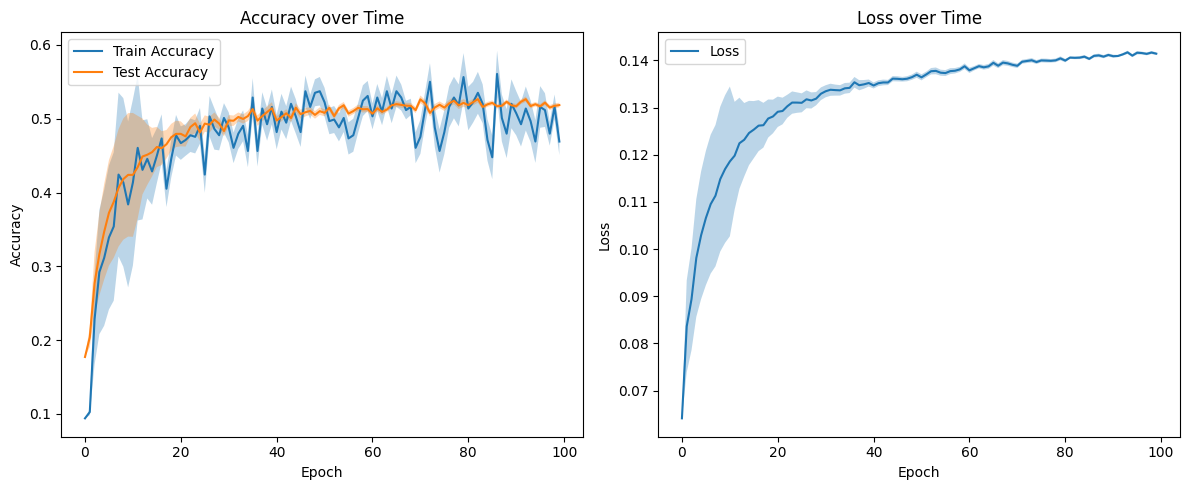

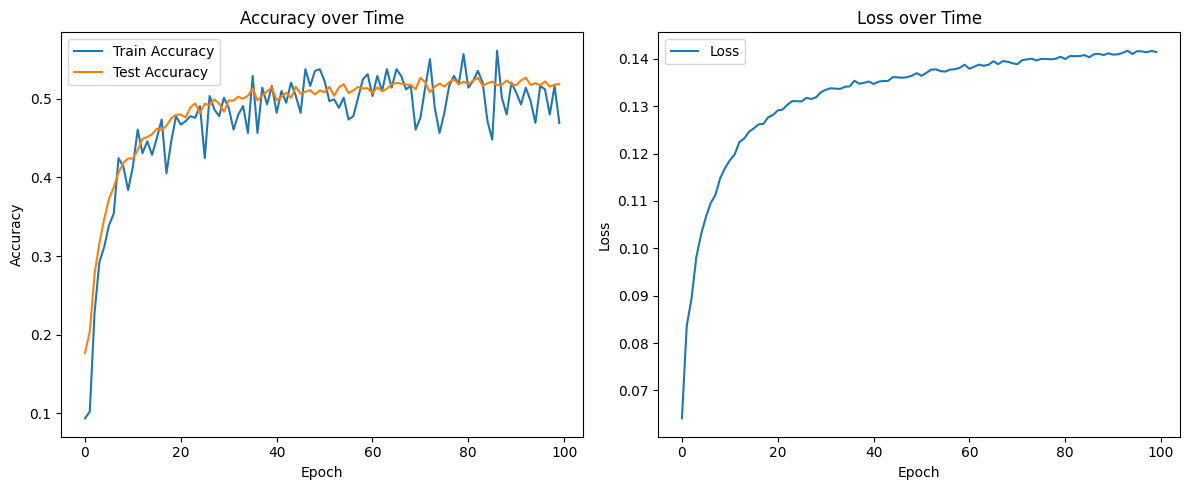

Final Train Accuracy: 0.47 ± 0.02
Final Test Accuracy: 0.52 ± 0.00


In [ ]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 32,
    "grid": 3,
    "method": "MLP",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2, # 4, 8
    "num_conv_layers": 1, # 2, 3
    "first_channel": 1, # (1,8,8) or (3,8,8)
    "hidden_dim": 128,
    "feature_selection": False,
    "distribution": "beta", # "bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

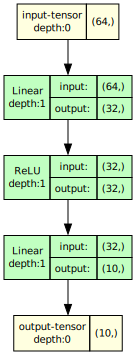

In [ ]:
## MLP architecture
import torchvision
from torchview import draw_graph

model_graph = draw_graph(q_network, input_size=(8 * 8,), expand_nested=True)
model_graph.visual_graph

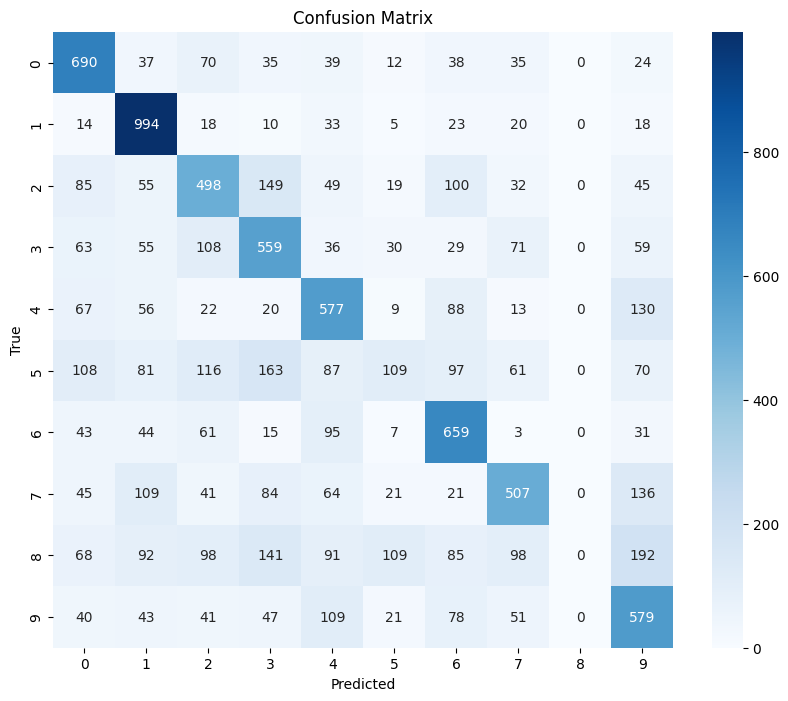

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
      # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
      # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
      # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
    for images, labels in DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                    #split='test', download=True, transform=transforms.Compose([
                                                 #train=False, download=True, transform=transforms.Compose([
      transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      #transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.70      0.63       980
           1       0.63      0.88      0.74      1135
           2       0.46      0.48      0.47      1032
           3       0.46      0.55      0.50      1010
           4       0.49      0.59      0.53       982
           5       0.32      0.12      0.18       892
           6       0.54      0.69      0.61       958
           7       0.57      0.49      0.53      1028
           8       0.00      0.00      0.00       974
           9       0.45      0.57      0.51      1009

    accuracy                           0.52     10000
   macro avg       0.45      0.51      0.47     10000
weighted avg       0.45      0.52      0.48     10000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


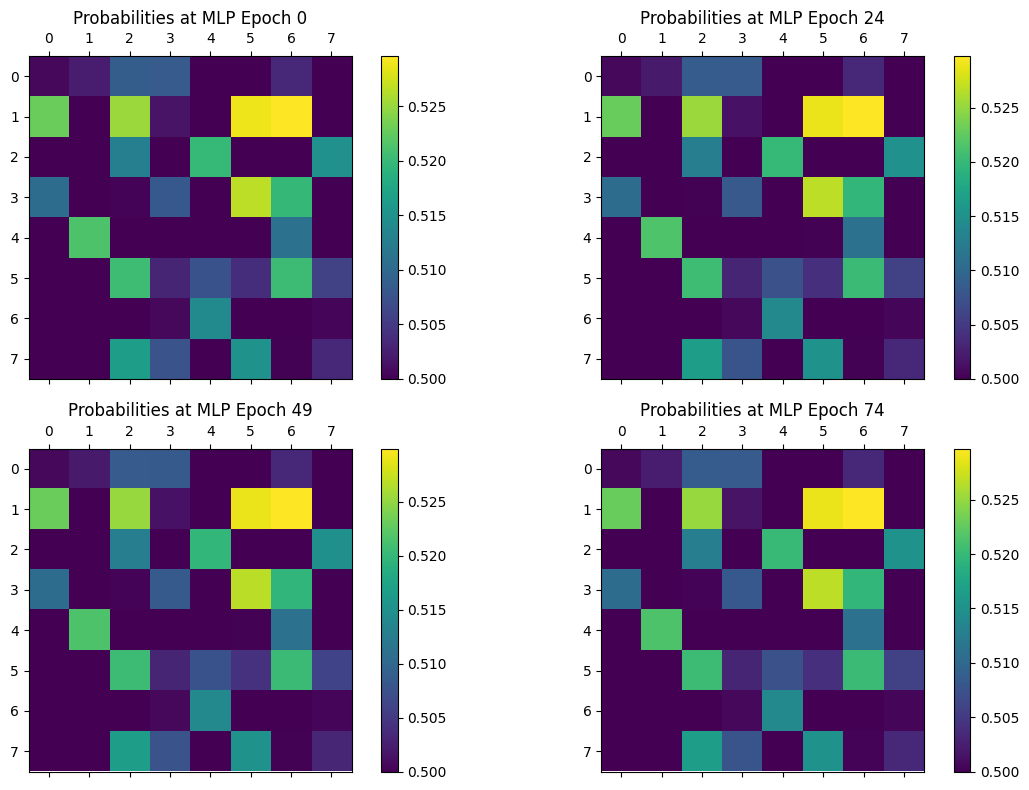

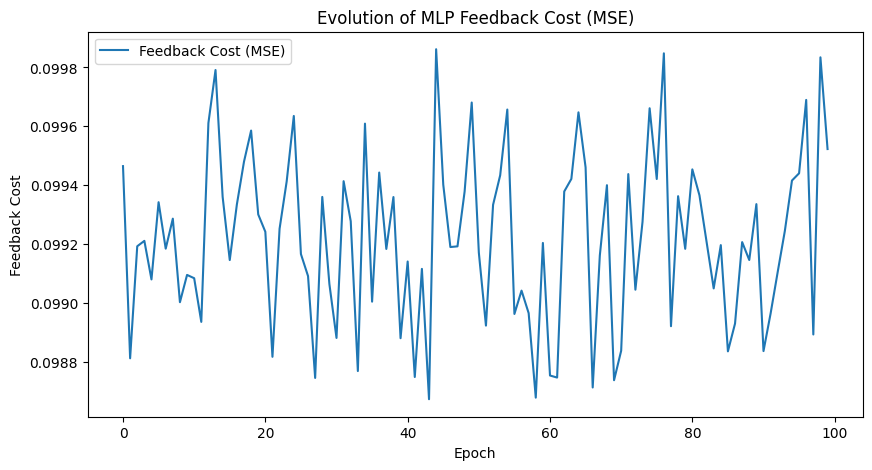

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at MLP Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of MLP Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


In [ ]:
import gc
gc.collect()

55411

# KAN

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
64


KAN_SVHN_0_1730478714:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06588705946832324
 Train accuracy:  0.09381663113006397 | 


KAN_SVHN_0_1730478714:   1%|          | 1/100 [01:52<3:05:12, 112.25s/it]

 Test accuracy:  0.1215

correct: 48 total: 469
loss: 0.06147589204884541
 Train accuracy:  0.1023454157782516 | 


KAN_SVHN_0_1730478714:   2%|▏         | 2/100 [04:29<3:46:28, 138.66s/it]

 Test accuracy:  0.1866

correct: 96 total: 469
loss: 0.05934041582826358
 Train accuracy:  0.2046908315565032 | 


KAN_SVHN_0_1730478714:   3%|▎         | 3/100 [07:24<4:11:02, 155.28s/it]

 Test accuracy:  0.2089

correct: 98 total: 469
loss: 0.06304765926368201
 Train accuracy:  0.208955223880597 | 


KAN_SVHN_0_1730478714:   4%|▍         | 4/100 [10:19<4:20:48, 163.01s/it]

 Test accuracy:  0.2073

correct: 90 total: 469
loss: 0.06635904932485968
 Train accuracy:  0.19189765458422176 | 


KAN_SVHN_0_1730478714:   5%|▌         | 5/100 [13:16<4:26:12, 168.13s/it]

 Test accuracy:  0.1922

correct: 72 total: 469
loss: 0.06987211804813159
 Train accuracy:  0.1535181236673774 | 


KAN_SVHN_0_1730478714:   6%|▌         | 6/100 [16:13<4:28:09, 171.16s/it]

 Test accuracy:  0.1882

correct: 94 total: 469
loss: 0.07331807603205699
 Train accuracy:  0.20042643923240938 | 


KAN_SVHN_0_1730478714:   7%|▋         | 7/100 [19:11<4:28:30, 173.23s/it]

 Test accuracy:  0.2008

correct: 99 total: 469
loss: 0.0761786943464391
 Train accuracy:  0.21108742004264391 | 


KAN_SVHN_0_1730478714:   8%|▊         | 8/100 [22:07<4:27:22, 174.37s/it]

 Test accuracy:  0.2009

correct: 80 total: 469
loss: 0.07670993539792642
 Train accuracy:  0.17057569296375266 | 


KAN_SVHN_0_1730478714:   9%|▉         | 9/100 [25:05<4:25:58, 175.36s/it]

 Test accuracy:  0.2069

correct: 98 total: 469
loss: 0.07914741866306456
 Train accuracy:  0.208955223880597 | 


KAN_SVHN_0_1730478714:  10%|█         | 10/100 [28:03<4:24:22, 176.25s/it]

 Test accuracy:  0.204

correct: 102 total: 469
loss: 0.08143526873291174
 Train accuracy:  0.21748400852878466 | 


KAN_SVHN_0_1730478714:  11%|█         | 11/100 [31:03<4:22:55, 177.25s/it]

 Test accuracy:  0.1969

correct: 102 total: 469
loss: 0.08406471235475052
 Train accuracy:  0.21748400852878466 | 


KAN_SVHN_0_1730478714:  12%|█▏        | 12/100 [34:03<4:21:10, 178.08s/it]

 Test accuracy:  0.2124

correct: 101 total: 469
loss: 0.08624710519113012
 Train accuracy:  0.21535181236673773 | 


KAN_SVHN_0_1730478714:  13%|█▎        | 13/100 [37:02<4:18:44, 178.44s/it]

 Test accuracy:  0.2051

correct: 107 total: 469
loss: 0.08733541249974704
 Train accuracy:  0.2281449893390192 | 


KAN_SVHN_0_1730478714:  14%|█▍        | 14/100 [40:01<4:16:08, 178.70s/it]

 Test accuracy:  0.2232

correct: 88 total: 469
loss: 0.08847490731459945
 Train accuracy:  0.18763326226012794 | 


KAN_SVHN_0_1730478714:  15%|█▌        | 15/100 [43:02<4:13:59, 179.29s/it]

 Test accuracy:  0.2236

correct: 100 total: 469
loss: 0.08842412045578966
 Train accuracy:  0.21321961620469082 | 


KAN_SVHN_0_1730478714:  16%|█▌        | 16/100 [46:03<4:11:40, 179.76s/it]

 Test accuracy:  0.222

correct: 104 total: 469
loss: 0.09075995121619848
 Train accuracy:  0.22174840085287847 | 


KAN_SVHN_0_1730478714:  17%|█▋        | 17/100 [49:03<4:08:58, 179.98s/it]

 Test accuracy:  0.229

correct: 105 total: 469
loss: 0.09174276707268982
 Train accuracy:  0.22388059701492538 | 


KAN_SVHN_0_1730478714:  18%|█▊        | 18/100 [52:03<4:05:56, 179.96s/it]

 Test accuracy:  0.2327

correct: 98 total: 469
loss: 0.09187059174341433
 Train accuracy:  0.208955223880597 | 


KAN_SVHN_0_1730478714:  19%|█▉        | 19/100 [55:03<4:03:03, 180.05s/it]

 Test accuracy:  0.2345

correct: 107 total: 469
loss: 0.0938902912713063
 Train accuracy:  0.2281449893390192 | 


KAN_SVHN_0_1730478714:  20%|██        | 20/100 [58:04<4:00:18, 180.23s/it]

 Test accuracy:  0.234

correct: 117 total: 469
loss: 0.0959150418639183
 Train accuracy:  0.24946695095948826 | 


KAN_SVHN_0_1730478714:  21%|██        | 21/100 [1:01:06<3:57:59, 180.76s/it]

 Test accuracy:  0.2368

correct: 109 total: 469
loss: 0.09708731705700156
 Train accuracy:  0.232409381663113 | 


KAN_SVHN_0_1730478714:  22%|██▏       | 22/100 [1:04:06<3:54:47, 180.61s/it]

 Test accuracy:  0.2407

correct: 101 total: 469
loss: 0.09719419598515862
 Train accuracy:  0.21535181236673773 | 


KAN_SVHN_0_1730478714:  23%|██▎       | 23/100 [1:07:07<3:51:39, 180.51s/it]

 Test accuracy:  0.2431

correct: 114 total: 469
loss: 0.09760642760216809
 Train accuracy:  0.24307036247334754 | 


KAN_SVHN_0_1730478714:  24%|██▍       | 24/100 [1:10:10<3:49:38, 181.29s/it]

 Test accuracy:  0.2439

correct: 136 total: 469
loss: 0.10038560789340595
 Train accuracy:  0.2899786780383795 | 


KAN_SVHN_0_1730478714:  25%|██▌       | 25/100 [1:13:11<3:46:35, 181.28s/it]

 Test accuracy:  0.2615

correct: 114 total: 469
loss: 0.10042595631405235
 Train accuracy:  0.24307036247334754 | 


KAN_SVHN_0_1730478714:  26%|██▌       | 26/100 [1:16:45<3:55:34, 191.00s/it]

 Test accuracy:  0.3227

correct: 149 total: 469
loss: 0.10831163817250145
 Train accuracy:  0.31769722814498935 | 


KAN_SVHN_0_1730478714:  27%|██▋       | 27/100 [1:19:46<3:48:44, 188.00s/it]

 Test accuracy:  0.3693

correct: 199 total: 469
loss: 0.10597495407437973
 Train accuracy:  0.42430703624733473 | 


KAN_SVHN_0_1730478714:  28%|██▊       | 28/100 [1:22:47<3:43:05, 185.92s/it]

 Test accuracy:  0.3792

correct: 181 total: 469
loss: 0.10643690308210438
 Train accuracy:  0.3859275053304904 | 


KAN_SVHN_0_1730478714:  29%|██▉       | 29/100 [1:25:48<3:38:19, 184.50s/it]

 Test accuracy:  0.4104

correct: 187 total: 469
loss: 0.10598808445973691
 Train accuracy:  0.39872068230277186 | 


KAN_SVHN_0_1730478714:  30%|███       | 30/100 [1:28:57<3:36:59, 186.00s/it]

 Test accuracy:  0.4033

correct: 211 total: 469
loss: 0.1054829985443463
 Train accuracy:  0.44989339019189767 | 


KAN_SVHN_0_1730478714:  31%|███       | 31/100 [1:32:07<3:35:00, 186.97s/it]

 Test accuracy:  0.4383

correct: 219 total: 469
loss: 0.10529078157153973
 Train accuracy:  0.4669509594882729 | 


KAN_SVHN_0_1730478714:  32%|███▏      | 32/100 [1:35:15<3:32:27, 187.46s/it]

 Test accuracy:  0.4608

correct: 223 total: 469
loss: 0.10486490492309843
 Train accuracy:  0.47547974413646055 | 


KAN_SVHN_0_1730478714:  33%|███▎      | 33/100 [1:38:22<3:29:03, 187.22s/it]

 Test accuracy:  0.4752

correct: 221 total: 469
loss: 0.10516226782536964
 Train accuracy:  0.47121535181236673 | 


KAN_SVHN_0_1730478714:  34%|███▍      | 34/100 [1:41:30<3:26:14, 187.50s/it]

 Test accuracy:  0.475

correct: 217 total: 469
loss: 0.10463346920605661
 Train accuracy:  0.4626865671641791 | 


KAN_SVHN_0_1730478714:  35%|███▌      | 35/100 [1:44:40<3:23:57, 188.27s/it]

 Test accuracy:  0.4854

correct: 225 total: 469
loss: 0.10506174023916472
 Train accuracy:  0.47974413646055436 | 


KAN_SVHN_0_1730478714:  36%|███▌      | 36/100 [1:47:49<3:20:53, 188.33s/it]

 Test accuracy:  0.4921

correct: 206 total: 469
loss: 0.10599527903584274
 Train accuracy:  0.43923240938166314 | 


KAN_SVHN_0_1730478714:  37%|███▋      | 37/100 [1:50:58<3:18:00, 188.58s/it]

 Test accuracy:  0.498

correct: 246 total: 469
loss: 0.10654386247335466
 Train accuracy:  0.5245202558635395 | 


KAN_SVHN_0_1730478714:  38%|███▊      | 38/100 [1:54:06<3:14:48, 188.52s/it]

 Test accuracy:  0.5102

correct: 235 total: 469
loss: 0.10763492012646661
 Train accuracy:  0.5010660980810234 | 


KAN_SVHN_0_1730478714:  39%|███▉      | 39/100 [1:57:15<3:11:55, 188.77s/it]

 Test accuracy:  0.4952

correct: 234 total: 469
loss: 0.10715649974371579
 Train accuracy:  0.4989339019189765 | 


KAN_SVHN_0_1730478714:  40%|████      | 40/100 [2:00:23<3:08:21, 188.36s/it]

 Test accuracy:  0.5136

correct: 254 total: 469
loss: 0.10769830610769898
 Train accuracy:  0.5415778251599147 | 


KAN_SVHN_0_1730478714:  41%|████      | 41/100 [2:03:31<3:05:16, 188.41s/it]

 Test accuracy:  0.5104

correct: 253 total: 469
loss: 0.1082885214355963
 Train accuracy:  0.5394456289978679 | 


KAN_SVHN_0_1730478714:  42%|████▏     | 42/100 [2:06:39<3:01:54, 188.18s/it]

 Test accuracy:  0.516

correct: 239 total: 469
loss: 0.1092242978687988
 Train accuracy:  0.509594882729211 | 


KAN_SVHN_0_1730478714:  43%|████▎     | 43/100 [2:09:47<2:58:51, 188.27s/it]

 Test accuracy:  0.5144

correct: 244 total: 469
loss: 0.10912254436819284
 Train accuracy:  0.5202558635394456 | 


KAN_SVHN_0_1730478714:  44%|████▍     | 44/100 [2:12:57<2:56:05, 188.68s/it]

 Test accuracy:  0.5243

correct: 254 total: 469
loss: 0.10992497204145643
 Train accuracy:  0.5415778251599147 | 


KAN_SVHN_0_1730478714:  45%|████▌     | 45/100 [2:16:07<2:53:24, 189.17s/it]

 Test accuracy:  0.5195

correct: 246 total: 469
loss: 0.11052916186260008
 Train accuracy:  0.5245202558635395 | 


KAN_SVHN_0_1730478714:  46%|████▌     | 46/100 [2:19:16<2:50:11, 189.11s/it]

 Test accuracy:  0.5214

correct: 254 total: 469
loss: 0.1101414377946081
 Train accuracy:  0.5415778251599147 | 


KAN_SVHN_0_1730478714:  47%|████▋     | 47/100 [2:22:26<2:47:09, 189.24s/it]

 Test accuracy:  0.5298

correct: 249 total: 469
loss: 0.11125692043667917
 Train accuracy:  0.5309168443496801 | 


KAN_SVHN_0_1730478714:  48%|████▊     | 48/100 [2:25:34<2:43:43, 188.91s/it]

 Test accuracy:  0.5349

correct: 254 total: 469
loss: 0.11211260563846845
 Train accuracy:  0.5415778251599147 | 


KAN_SVHN_0_1730478714:  49%|████▉     | 49/100 [2:28:43<2:40:35, 188.94s/it]

 Test accuracy:  0.5367

correct: 252 total: 469
loss: 0.11248725643163042
 Train accuracy:  0.5373134328358209 | 


KAN_SVHN_0_1730478714:  50%|█████     | 50/100 [2:31:53<2:37:35, 189.12s/it]

 Test accuracy:  0.5346

correct: 253 total: 469
loss: 0.11238562862184256
 Train accuracy:  0.5394456289978679 | 


KAN_SVHN_0_1730478714:  51%|█████     | 51/100 [2:35:02<2:34:28, 189.15s/it]

 Test accuracy:  0.5412

correct: 244 total: 469
loss: 0.11215076398557183
 Train accuracy:  0.5202558635394456 | 


KAN_SVHN_0_1730478714:  52%|█████▏    | 52/100 [2:38:12<2:31:35, 189.48s/it]

 Test accuracy:  0.5526

correct: 243 total: 469
loss: 0.11289638334881268
 Train accuracy:  0.5181236673773987 | 


KAN_SVHN_0_1730478714:  53%|█████▎    | 53/100 [2:41:21<2:28:24, 189.45s/it]

 Test accuracy:  0.5451

correct: 255 total: 469
loss: 0.113929872732681
 Train accuracy:  0.5437100213219617 | 


KAN_SVHN_0_1730478714:  54%|█████▍    | 54/100 [2:44:33<2:25:37, 189.94s/it]

 Test accuracy:  0.5555

correct: 237 total: 469
loss: 0.11425778376204627
 Train accuracy:  0.5053304904051172 | 


KAN_SVHN_0_1730478714:  55%|█████▌    | 55/100 [2:47:42<2:22:19, 189.77s/it]

 Test accuracy:  0.5504

correct: 242 total: 469
loss: 0.11405246978057727
 Train accuracy:  0.5159914712153518 | 


KAN_SVHN_0_1730478714:  56%|█████▌    | 56/100 [2:50:52<2:19:14, 189.88s/it]

 Test accuracy:  0.5474

correct: 247 total: 469
loss: 0.11384959412472588
 Train accuracy:  0.5266524520255863 | 


KAN_SVHN_0_1730478714:  57%|█████▋    | 57/100 [2:54:01<2:15:47, 189.48s/it]

 Test accuracy:  0.5483

correct: 259 total: 469
loss: 0.11461035559362949
 Train accuracy:  0.5522388059701493 | 


KAN_SVHN_0_1730478714:  58%|█████▊    | 58/100 [2:57:09<2:12:20, 189.05s/it]

 Test accuracy:  0.5518

correct: 244 total: 469
loss: 0.11571976974574742
 Train accuracy:  0.5202558635394456 | 


KAN_SVHN_0_1730478714:  59%|█████▉    | 59/100 [3:00:18<2:09:15, 189.16s/it]

 Test accuracy:  0.5507

correct: 276 total: 469
loss: 0.11574885539853497
 Train accuracy:  0.5884861407249466 | 


KAN_SVHN_0_1730478714:  60%|██████    | 60/100 [3:03:28<2:06:11, 189.30s/it]

 Test accuracy:  0.5552

correct: 238 total: 469
loss: 0.11565755348978267
 Train accuracy:  0.5074626865671642 | 


KAN_SVHN_0_1730478714:  61%|██████    | 61/100 [3:06:36<2:02:48, 188.93s/it]

 Test accuracy:  0.5512

correct: 259 total: 469
loss: 0.11578606440822707
 Train accuracy:  0.5522388059701493 | 


KAN_SVHN_0_1730478714:  62%|██████▏   | 62/100 [3:09:45<1:59:47, 189.15s/it]

 Test accuracy:  0.5596

correct: 273 total: 469
loss: 0.11678898487009727
 Train accuracy:  0.582089552238806 | 


KAN_SVHN_0_1730478714:  63%|██████▎   | 63/100 [3:12:55<1:56:47, 189.38s/it]

 Test accuracy:  0.5679

correct: 259 total: 469
loss: 0.11725647202623424
 Train accuracy:  0.5522388059701493 | 


KAN_SVHN_0_1730478714:  64%|██████▍   | 64/100 [3:16:07<1:54:05, 190.14s/it]

 Test accuracy:  0.5569

correct: 266 total: 469
loss: 0.11675469945869975
 Train accuracy:  0.5671641791044776 | 


KAN_SVHN_0_1730478714:  65%|██████▌   | 65/100 [3:19:17<1:50:51, 190.03s/it]

 Test accuracy:  0.5609

correct: 263 total: 469
loss: 0.11763386464894199
 Train accuracy:  0.5607675906183369 | 


KAN_SVHN_0_1730478714:  66%|██████▌   | 66/100 [3:22:32<1:48:35, 191.63s/it]

 Test accuracy:  0.5581

correct: 267 total: 469
loss: 0.11728498833710706
 Train accuracy:  0.5692963752665245 | 


KAN_SVHN_0_1730478714:  67%|██████▋   | 67/100 [3:25:42<1:44:59, 190.90s/it]

 Test accuracy:  0.5623

correct: 276 total: 469
loss: 0.11854249890297969
 Train accuracy:  0.5884861407249466 | 


KAN_SVHN_0_1730478714:  68%|██████▊   | 68/100 [3:28:52<1:41:47, 190.87s/it]

 Test accuracy:  0.5653

correct: 253 total: 469
loss: 0.11769954223177835
 Train accuracy:  0.5394456289978679 | 


KAN_SVHN_0_1730478714:  69%|██████▉   | 69/100 [3:32:04<1:38:42, 191.06s/it]

 Test accuracy:  0.5617

correct: 284 total: 469
loss: 0.11857136110189373
 Train accuracy:  0.605543710021322 | 


KAN_SVHN_0_1730478714:  70%|███████   | 70/100 [3:35:13<1:35:17, 190.59s/it]

 Test accuracy:  0.5714

correct: 251 total: 469
loss: 0.11862574562207977
 Train accuracy:  0.535181236673774 | 


KAN_SVHN_0_1730478714:  71%|███████   | 71/100 [3:38:23<1:32:01, 190.39s/it]

 Test accuracy:  0.5668

correct: 268 total: 469
loss: 0.11881172687196528
 Train accuracy:  0.5714285714285714 | 


KAN_SVHN_0_1730478714:  72%|███████▏  | 72/100 [3:41:34<1:28:56, 190.59s/it]

 Test accuracy:  0.5704

correct: 274 total: 469
loss: 0.11896533417358582
 Train accuracy:  0.5842217484008528 | 


KAN_SVHN_0_1730478714:  73%|███████▎  | 73/100 [3:44:46<1:25:53, 190.86s/it]

 Test accuracy:  0.5758

correct: 272 total: 469
loss: 0.11982809841188032
 Train accuracy:  0.579957356076759 | 


KAN_SVHN_0_1730478714:  74%|███████▍  | 74/100 [3:47:57<1:22:47, 191.07s/it]

 Test accuracy:  0.5726

correct: 259 total: 469
loss: 0.1203533927641952
 Train accuracy:  0.5522388059701493 | 


KAN_SVHN_0_1730478714:  75%|███████▌  | 75/100 [3:51:09<1:19:38, 191.16s/it]

 Test accuracy:  0.569

correct: 268 total: 469
loss: 0.1201993276410774
 Train accuracy:  0.5714285714285714 | 


KAN_SVHN_0_1730478714:  76%|███████▌  | 76/100 [3:54:19<1:16:18, 190.78s/it]

 Test accuracy:  0.565

correct: 273 total: 469
loss: 0.11974729480011377
 Train accuracy:  0.582089552238806 | 


KAN_SVHN_0_1730478714:  77%|███████▋  | 77/100 [3:57:29<1:13:04, 190.63s/it]

 Test accuracy:  0.5628

correct: 277 total: 469
loss: 0.12010062250819033
 Train accuracy:  0.5906183368869936 | 


KAN_SVHN_0_1730478714:  78%|███████▊  | 78/100 [4:00:40<1:09:58, 190.86s/it]

 Test accuracy:  0.5632

correct: 277 total: 469
loss: 0.12030387331427796
 Train accuracy:  0.5906183368869936 | 


KAN_SVHN_0_1730478714:  79%|███████▉  | 79/100 [4:03:50<1:06:39, 190.46s/it]

 Test accuracy:  0.5702

correct: 245 total: 469
loss: 0.12044878218219733
 Train accuracy:  0.5223880597014925 | 


KAN_SVHN_0_1730478714:  80%|████████  | 80/100 [4:06:59<1:03:23, 190.18s/it]

 Test accuracy:  0.5691

correct: 268 total: 469
loss: 0.1209721959380707
 Train accuracy:  0.5714285714285714 | 


KAN_SVHN_0_1730478714:  81%|████████  | 81/100 [4:10:10<1:00:12, 190.15s/it]

 Test accuracy:  0.5729

correct: 270 total: 469
loss: 0.1210696732502248
 Train accuracy:  0.5756929637526652 | 


KAN_SVHN_0_1730478714:  82%|████████▏ | 82/100 [4:13:18<56:56, 189.80s/it]  

 Test accuracy:  0.5704

correct: 255 total: 469
loss: 0.12203995429122372
 Train accuracy:  0.5437100213219617 | 


KAN_SVHN_0_1730478714:  83%|████████▎ | 83/100 [4:16:30<53:53, 190.19s/it]

 Test accuracy:  0.5538

correct: 261 total: 469
loss: 0.12232876972539593
 Train accuracy:  0.5565031982942431 | 


KAN_SVHN_0_1730478714:  84%|████████▍ | 84/100 [4:19:40<50:43, 190.24s/it]

 Test accuracy:  0.575

correct: 269 total: 469
loss: 0.12189114911914635
 Train accuracy:  0.5735607675906184 | 


KAN_SVHN_0_1730478714:  85%|████████▌ | 85/100 [4:22:50<47:31, 190.10s/it]

 Test accuracy:  0.5829

correct: 257 total: 469
loss: 0.1224356187718001
 Train accuracy:  0.5479744136460555 | 


KAN_SVHN_0_1730478714:  86%|████████▌ | 86/100 [4:26:00<44:22, 190.15s/it]

 Test accuracy:  0.5739

correct: 260 total: 469
loss: 0.12311156001934873
 Train accuracy:  0.5543710021321961 | 


KAN_SVHN_0_1730478714:  87%|████████▋ | 87/100 [4:29:12<41:17, 190.60s/it]

 Test accuracy:  0.5732

correct: 264 total: 469
loss: 0.12172136735369656
 Train accuracy:  0.5628997867803838 | 


KAN_SVHN_0_1730478714:  88%|████████▊ | 88/100 [4:32:23<38:11, 190.97s/it]

 Test accuracy:  0.5828

correct: 271 total: 469
loss: 0.12233769080277954
 Train accuracy:  0.5778251599147122 | 


KAN_SVHN_0_1730478714:  89%|████████▉ | 89/100 [4:35:34<34:59, 190.85s/it]

 Test accuracy:  0.5675

correct: 266 total: 469
loss: 0.12367468953196174
 Train accuracy:  0.5671641791044776 | 


KAN_SVHN_0_1730478714:  90%|█████████ | 90/100 [4:38:44<31:46, 190.63s/it]

 Test accuracy:  0.5769

correct: 266 total: 469
loss: 0.12298813381238279
 Train accuracy:  0.5671641791044776 | 


KAN_SVHN_0_1730478714:  91%|█████████ | 91/100 [4:41:56<28:39, 191.04s/it]

 Test accuracy:  0.5677

correct: 282 total: 469
loss: 0.12342917844494268
 Train accuracy:  0.6012793176972282 | 


KAN_SVHN_0_1730478714:  92%|█████████▏| 92/100 [4:45:09<25:33, 191.68s/it]

 Test accuracy:  0.5729

correct: 280 total: 469
loss: 0.12293389361740938
 Train accuracy:  0.5970149253731343 | 


KAN_SVHN_0_1730478714:  93%|█████████▎| 93/100 [4:48:22<22:24, 192.04s/it]

 Test accuracy:  0.5721

correct: 284 total: 469
loss: 0.12365558490887887
 Train accuracy:  0.605543710021322 | 


KAN_SVHN_0_1730478714:  94%|█████████▍| 94/100 [4:51:33<19:09, 191.64s/it]

 Test accuracy:  0.5824

correct: 263 total: 469
loss: 0.12427504578315372
 Train accuracy:  0.5607675906183369 | 


KAN_SVHN_0_1730478714:  95%|█████████▌| 95/100 [4:54:44<15:57, 191.47s/it]

 Test accuracy:  0.5738

correct: 253 total: 469
loss: 0.12392672111611885
 Train accuracy:  0.5394456289978679 | 


KAN_SVHN_0_1730478714:  96%|█████████▌| 96/100 [4:57:55<12:45, 191.28s/it]

 Test accuracy:  0.5787

correct: 253 total: 469
loss: 0.12429769367360866
 Train accuracy:  0.5394456289978679 | 


KAN_SVHN_0_1730478714:  97%|█████████▋| 97/100 [5:01:10<09:37, 192.34s/it]

 Test accuracy:  0.574

correct: 274 total: 469
loss: 0.12472760847318909
 Train accuracy:  0.5842217484008528 | 


KAN_SVHN_0_1730478714:  98%|█████████▊| 98/100 [5:04:24<06:25, 192.95s/it]

 Test accuracy:  0.5859

correct: 244 total: 469
loss: 0.12389862693067807
 Train accuracy:  0.5202558635394456 | 


KAN_SVHN_0_1730478714:  99%|█████████▉| 99/100 [5:07:36<03:12, 192.67s/it]

 Test accuracy:  0.5831

correct: 262 total: 469
loss: 0.12464472276569684
 Train accuracy:  0.55863539445629 | 


KAN_SVHN_0_1730478714: 100%|██████████| 100/100 [5:10:50<00:00, 186.51s/it]

 Test accuracy:  0.5814


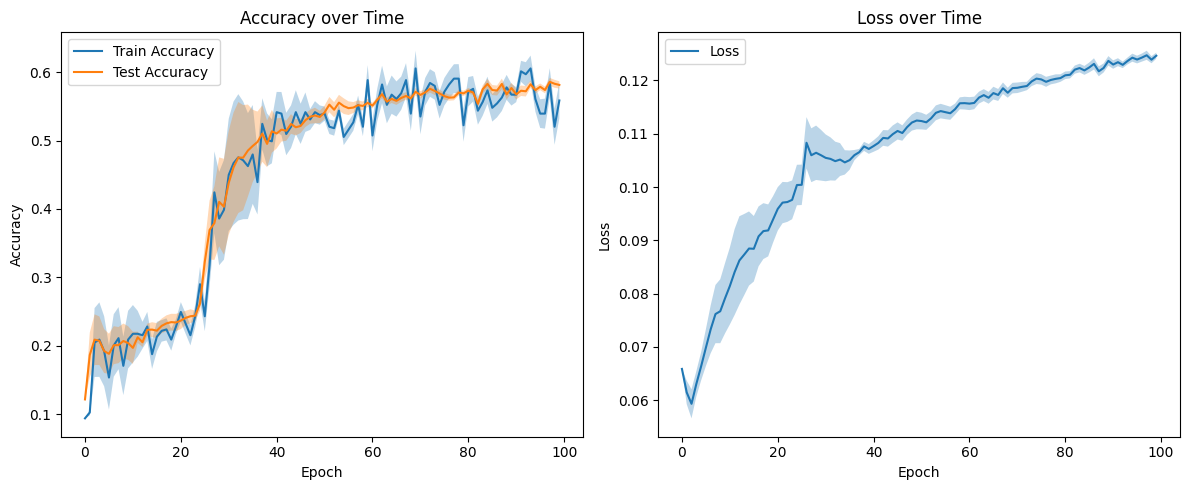

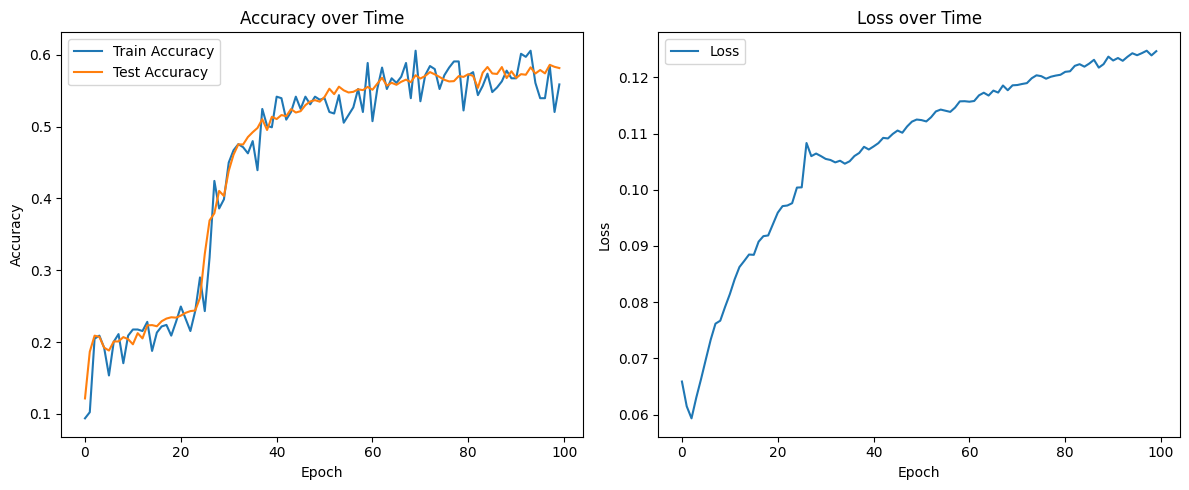

Final Train Accuracy: 0.56 ± 0.03
Final Test Accuracy: 0.58 ± 0.01


In [ ]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 8,
    "grid": 3,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2,
    "num_conv_layers": 1,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": False,
    "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

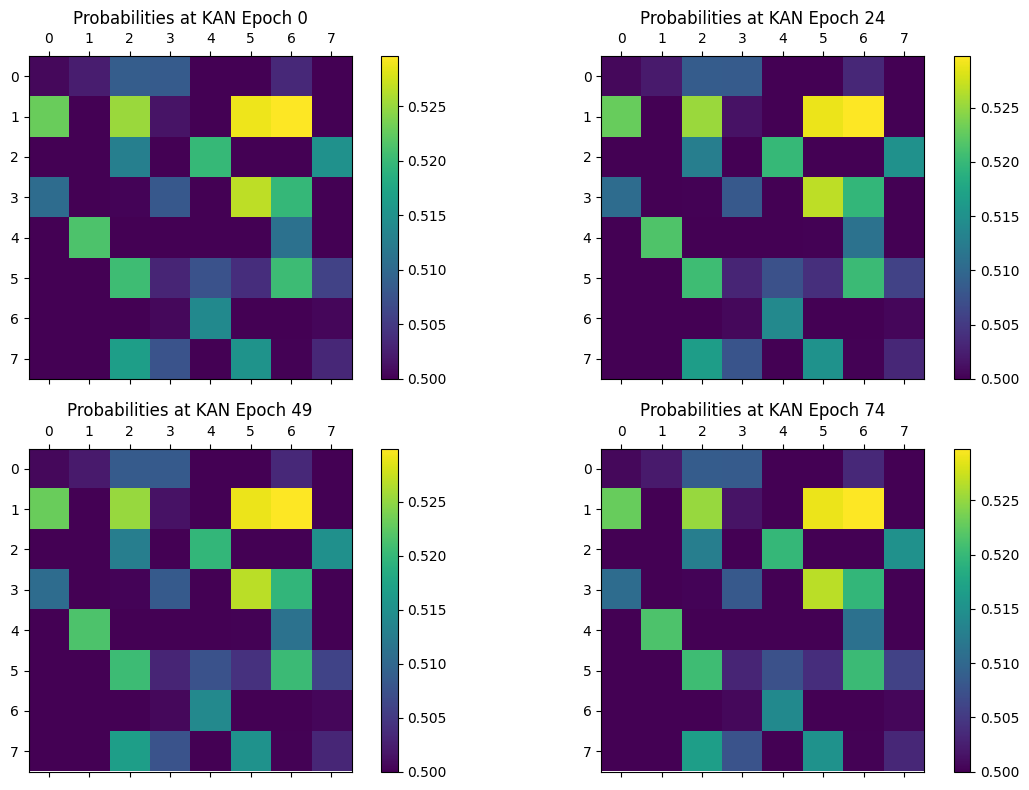

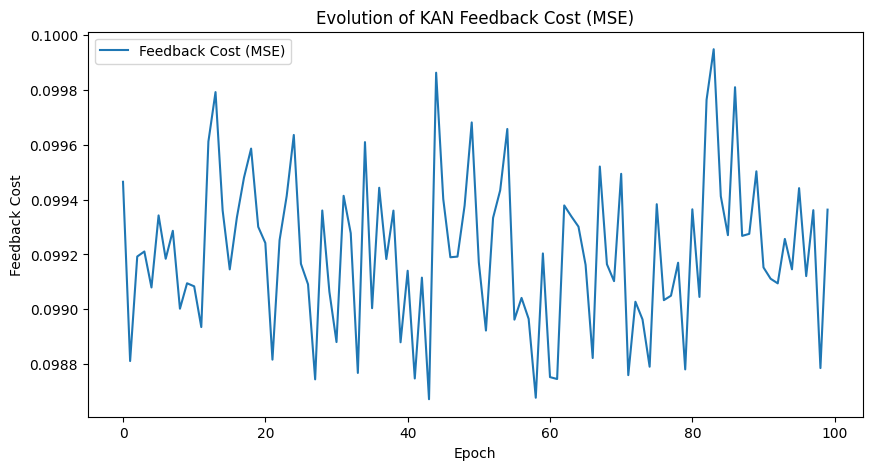

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at KAN Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of KAN Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


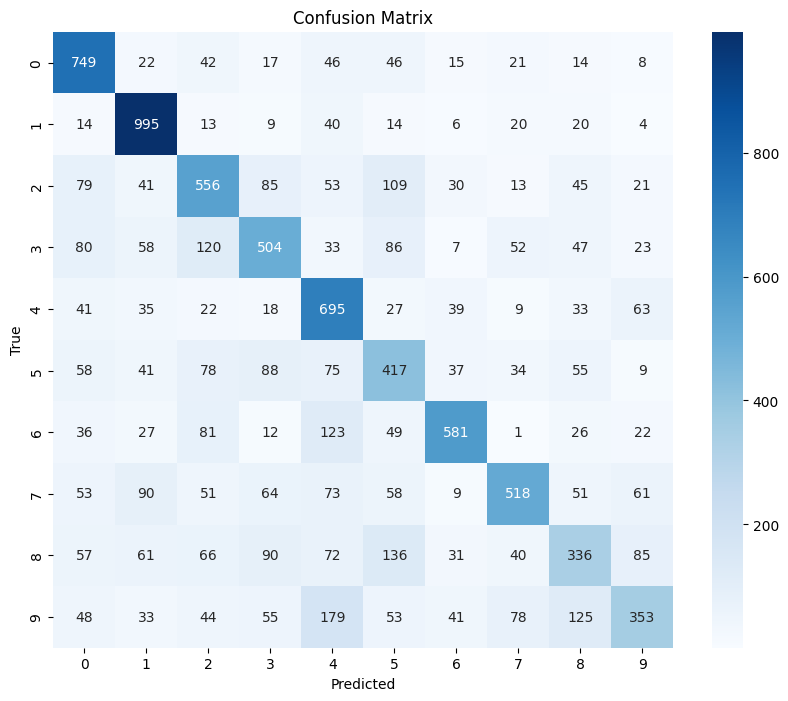

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
      # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
      # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
      # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
    for images, labels in DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                    #split='test', download=True, transform=transforms.Compose([
                                                 #train=False, download=True, transform=transforms.Compose([
      transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      #transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.76      0.68       980
           1       0.71      0.88      0.78      1135
           2       0.52      0.54      0.53      1032
           3       0.54      0.50      0.52      1010
           4       0.50      0.71      0.59       982
           5       0.42      0.47      0.44       892
           6       0.73      0.61      0.66       958
           7       0.66      0.50      0.57      1028
           8       0.45      0.34      0.39       974
           9       0.54      0.35      0.43      1009

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.57      0.57      0.56     10000



In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

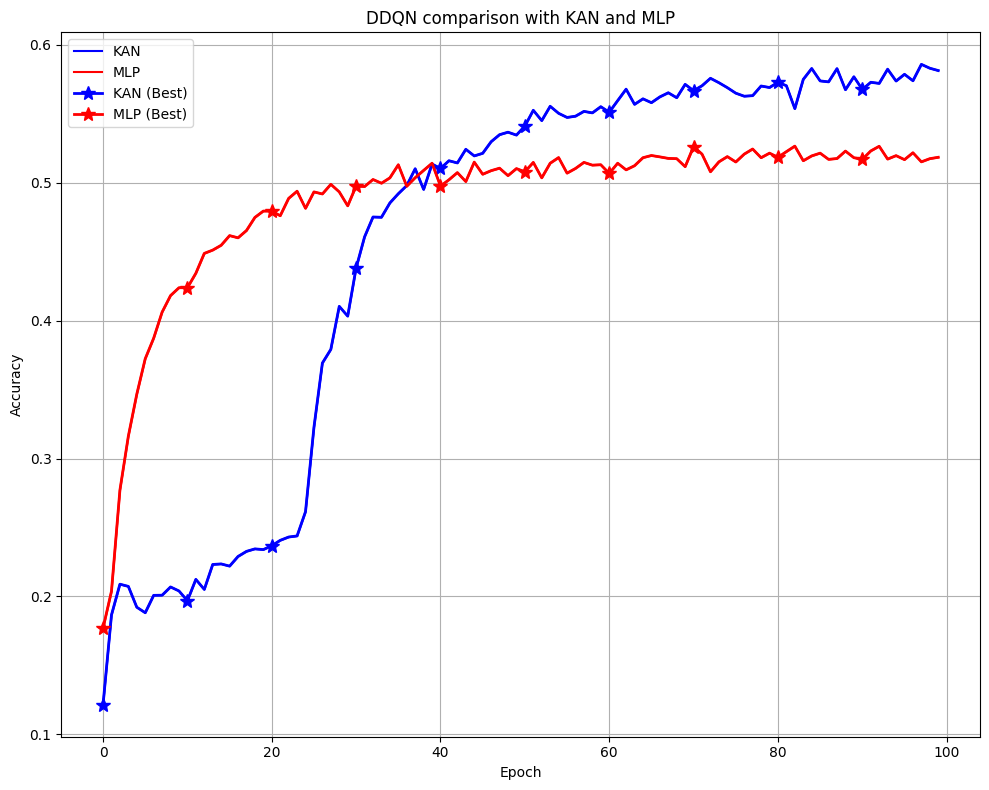

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import glob


algo1, algo2 = 'KAN', 'MLP'

files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

plt.figure(figsize=(10, 8))

plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'DDQN comparison with {algo1} and {algo2}')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
import gc
gc.collect()

59689

In [ ]:
# q_network.prune()

In [ ]:
# q_network.plot(beta=30, scale=1, out_vars=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
# lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
# q_network.auto_symbolic(lib=lib)

In [ ]:
# symbolic_formula = f"### The symbolic formula of the policy is:"
# formulas = q_network.symbolic_formula()[0]

In [ ]:
# from sympy import latex
# import glob
# import os

# import gymnasium as gym
# import numpy as np
# from gymnasium.wrappers import RecordVideo
# from moviepy.video.compositing.concatenate import concatenate_videoclips
# from moviepy.video.io.VideoFileClip import VideoFileClip
# from sympy import latex
# import matplotlib.pyplot as plt


# for i, formula in enumerate(formulas):
#     symbolic_formula += "\n$$ a_" + str(i) + "=" + latex(formula) + "$$"
# symbolic_formula += "\n" + r"$$ a = \underset{i}{\mathrm{argmax}} \ a_i.$$"

In [ ]:
# print(symbolic_formula)

In [ ]:
# formulas[0] # formula of a_0

In [ ]:
# print(formulas[0])

In [ ]:
# formulas

In [ ]:
# import re
# from collections import Counter
# import matplotlib.pyplot as plt

# # Given symbolic formula (abbreviated for clarity)
# formula = str(formulas)

# # Extract all feature occurrences
# features = re.findall(r'x_\d+', formula)

# # Count feature occurrences
# feature_counts = Counter(features)

# # Extract coefficients for the features
# coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
# coefficients = [float(c) for c in coefficients]

# # Combine frequency and coefficient magnitude for importance
# feature_importance = {}
# for feature in feature_counts:
#     feature_importance[feature] = feature_counts[feature]

# # Sort features by importance
# sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# # Plotting feature importance
# features, importance = zip(*sorted_features)
# plt.figure(figsize=(12, 8))
# plt.bar(features, importance)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Feature Importance')
# plt.xticks(rotation=90)
# plt.show()


In [ ]:
# import re
# from collections import Counter
# import matplotlib.pyplot as plt

# def parse_formula(formula):
#     # Extract all feature occurrences
#     features = re.findall(r'x_\d+', formula)
#     # Extract coefficients for the features
#     coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
#     coefficients = [float(c) for c in coefficients]
#     return features, coefficients

# def compute_feature_importance(features, coefficients):
#     # Count feature occurrences
#     feature_counts = Counter(features)
#     # Combine frequency and coefficient magnitude for importance
#     feature_importance = {}
#     for feature in feature_counts:
#         feature_importance[feature] = feature_counts[feature]
#     return feature_importance

# # Plot feature importance for each component
# fig, axes = plt.subplots(5, 2, figsize=(15, 25))
# axes = axes.flatten()

# for i, formula in enumerate(formulas):
#     features, coefficients = parse_formula(str(formula))
#     feature_importance = compute_feature_importance(features, coefficients)

#     # Sort features by importance
#     sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

#     # Plotting feature importance
#     features, importance = zip(*sorted_features)
#     axes[i].bar(features, importance)
#     axes[i].set_xlabel('Features')
#     axes[i].set_ylabel('Importance')
#     axes[i].set_title(f'Feature Importance for a_{i}')
#     axes[i].tick_params(axis='x', rotation=90)

# plt.tight_layout()
# plt.show()


First Part: Activation Functions for the Middle Neurons in the First Hidden Layer

Objective: Plot activation functions for the middle neurons in the first hidden layer.
Setup: A 2x6 grid (2 rows, 6 columns) for plotting.
Loop: Iterate over input neurons (i = 0 and i = 1) and middle neurons (j = 0 to 5).
Layer: l = 1 corresponds to the first hidden layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

In [ ]:
# # Create a 2x6 grid for plotting (2 rows, 6 columns)
# fig, axs = plt.subplots(8, 2, figsize=(10, 35))
# middle_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Output neurons in the first hidden layer
# input_neurons = [0, 1]

# model = q_network

# for row, i in enumerate(middle_neurons):  # Input neurons i = 0 and i = 1
#     for col, j in enumerate(input_neurons):
#         l = 1  # Layer index (first hidden layer)

#         # Extract inputs and outputs of the spline activation functions
#         inputs = model.spline_preacts[l][:, i, j]
#         outputs = model.spline_postacts[l][:, i, j]

#         # Sort the inputs and corresponding outputs for plotting
#         rank = np.argsort(inputs)
#         inputs = inputs[rank]
#         outputs = outputs[rank]

#         # Determine subplot location
#         ax = axs[row, col]

#         # Plot the activation function
#         ax.plot(inputs, outputs, marker="o")
#         ax.set_title(f'Activation Function\nLayer {l}, Input Neuron {i}, Output Neuron {j}')
#         ax.set_xlabel('Input')
#         ax.set_ylabel('Output')
#         ax.grid(True)

# plt.tight_layout(pad=3)
# plt.show()


Second Part: Activation Functions Between the First Hidden Layer and the Output Layer

Objective: Plot activation functions for the neurons between the first hidden layer and the output layer.
Setup: A 6x2 grid (6 rows, 2 columns) for plotting.
Loop: Iterate over hidden neurons (i = 0 to 5) and output neurons (j = 0 and j = 1).
Layer: l = 1 corresponds to the output layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

In [ ]:
# # Extract and plot activation functions for the neurons between the first hidden layer and the output layer
# hidden_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Neurons in the first hidden layer
# output_neurons = [0, 1]  # Neurons in the output layer

# # Create a 3x2 grid for plotting
# fig, axs = plt.subplots(8, 2, figsize=(10, 35))

# for row, i in enumerate(hidden_neurons):  # Neurons in the first hidden layer
#     for col, j in enumerate(output_neurons):  # Neurons in the output layer
#         l = 1  # Layer index (output layer)

#         # Extract inputs and outputs of the spline activation functions
#         inputs = model.spline_preacts[l][:, j, i]
#         outputs = model.spline_postacts[l][:, j, i]

#         # Sort the inputs and corresponding outputs for plotting
#         rank = np.argsort(inputs)
#         inputs = inputs[rank]
#         outputs = outputs[rank]

#         # Determine subplot location
#         ax = axs[row, col]

#         # Plot the activation function
#         ax.plot(inputs, outputs, marker="o")
#         ax.set_title(f'Activation Function\nLayer {l}, Hidden Neuron {i}, Output Neuron {j}')
#         ax.set_xlabel('Input')
#         ax.set_ylabel('Output')
#         ax.grid(True)

# # Add space between subplots
# plt.tight_layout(pad=3.0)
# plt.show()

# Tensorboard

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

In [ ]:
# import gc
# gc.collect()

In [ ]:
# import sys
# import pandas as pd
# import matplotlib.pyplot as plt
# import glob


# algo1, algo2 = 'KAN', 'MLP'

# files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
# files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

# df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
# df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

# median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
# median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
# quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
# quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
# quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
# quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

# best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
# best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

# plt.figure(figsize=(10, 8))

# plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
# plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

# plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
# plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

# plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

# plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title(f'DDQN comparison with {algo1} and {algo2}')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# plt.show()


In [ ]:
# from google.colab import files
# files.download('/content/results/KAN_MNIST_0_1720304363.csv')

In [ ]:
# import matplotlib.pyplot as plt
# from sympy import symbols, lambdify, exp, sin, cos, log, sqrt, tan
# import numpy as np

# # Define 10 symbolic variables
# x_symbols = symbols('x_1:11')  # x_1, x_2, ..., x_10

# # Example list of 10 formulas, each involving the 10 variables
# # formulas = [
# #     0.5*x_symbols[0] + 0.3*x_symbols[1]**2 - 0.2*x_symbols[2] + 0.1*x_symbols[3]**2,
# #     exp(0.5*x_symbols[4]) - 0.8*sin(x_symbols[5]) + 0.3*cos(x_symbols[6]),
# #     log(x_symbols[7] + 2) + sqrt(abs(x_symbols[8])) - 0.4*x_symbols[9],
# #     0.2*x_symbols[0]**3 - 0.3*sin(x_symbols[1]) + 0.7*x_symbols[2]**2 + cos(x_symbols[3]),
# #     sinh(x_symbols[4]) - cosh(x_symbols[5]) + 0.5*x_symbols[6]**2,
# #     tan(x_symbols[7]) + 0.1*log(x_symbols[8] + 1) - 0.2*x_symbols[9]**2,
# #     exp(-0.5*x_symbols[0]) + 0.3*x_symbols[1]**3 - 0.7*x_symbols[2] + sqrt(x_symbols[3] + 4),
# #     0.4*sin(x_symbols[4]) + 0.6*cos(x_symbols[5] + x_symbols[6]**2) - 0.2*tan(x_symbols[7]),
# #     log(x_symbols[8] + 3) + exp(x_symbols[9]) - 0.1*x_symbols[0] + 0.3*x_symbols[1],
# #     sinh(x_symbols[2]) + cosh(x_symbols[3] - 1) - sin(x_symbols[4]) + 0.5*x_symbols[5]**2
# # ]

# # Generate values for the variables
# x_values = np.linspace(-2, 2, 400)  # Values for the variable being varied
# fixed_values = [0] * 10  # Initial fixed values for the other variables

# # Set up subplots
# fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5x2 grid of subplots
# axes = axes.flatten()  # Flatten the axes array for easy indexing

# # Plot each variable's influence in its own subplot
# for i in range(len(x_symbols)):
#     axes[i].set_title(f'Effect of {x_symbols[i]} on the formulas', fontsize=14)
#     axes[i].set_xlabel(f'{x_symbols[i]}', fontsize=12)
#     axes[i].set_ylabel('f(x)', fontsize=12)

#     # Iterate through each formula
#     for j, formula in enumerate(formulas):
#         # Lambdify the current formula with all 10 variables
#         f = lambdify(x_symbols, formula, "numpy")

#         # Compute y values for varying the i-th variable
#         y_values = []
#         for val in x_values:
#             current_values = fixed_values.copy()  # Start with fixed values
#             current_values[i] = val  # Vary the i-th variable
#             y_values.append(f(*current_values))

#         # Plot the function corresponding to the j-th formula
#         axes[i].plot(x_values, y_values, label=f"$a_{j}$")

#     axes[i].grid(True)
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig('10_formulas_plot.png', dpi=300)
# plt.show()


https://daniel-bethell.co.uk/posts/mccp/

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# Paper codes